In [1]:
import pandas as pd


In [2]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')
#we must specify the different encoding other than utf, it doesnt run as it cant decode all the data.

### Here the data is not just 5000, so we are going to iterate the chunks and then run the statement.

In [3]:
cb_length = []

# looking at dataset's length
for chunk in chunk_iter:
    cb_length.append(len(chunk))

cb_length = sum(cb_length)

print(f"Total number of rows in the dataset: {cb_length}")

Total number of rows in the dataset: 52870


### Now we are going to re initialize and look for missing values.

In [4]:
# Counting missing values by column
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')
#empty list
mv_list = []
for chunk in chunk_iter:
    if not mv_list:  # check if mv_list is empty
        columns = chunk.columns
        print(columns.sort_values())
    mv_list.append(chunk.isnull().sum())
combined_mv_vc = pd.concat(mv_list)
unique_combined_mv_vc = combined_mv_vc.groupby(combined_mv_vc.index).sum()
unique_combined_mv_vc

Index(['company_category_code', 'company_city', 'company_country_code',
       'company_name', 'company_permalink', 'company_region',
       'company_state_code', 'funded_at', 'funded_month', 'funded_quarter',
       'funded_year', 'funding_round_type', 'investor_category_code',
       'investor_city', 'investor_country_code', 'investor_name',
       'investor_permalink', 'investor_region', 'investor_state_code',
       'raised_amount_usd'],
      dtype='object')


company_category_code       643
company_city                533
company_country_code          1
company_name                  1
company_permalink             1
company_region                1
company_state_code          492
funded_at                     3
funded_month                  3
funded_quarter                3
funded_year                   3
funding_round_type            3
investor_category_code    50427
investor_city             12480
investor_country_code     12001
investor_name                 2
investor_permalink            2
investor_region               2
investor_state_code       16809
raised_amount_usd          3599
dtype: int64

#### As we can see, we have around 52k rows and the investor category code has around 50k empty columns which makes it a good choice to drop the column.

#### Now lets look at the memory usage of the columns.

In [5]:
# Total memory footprint for each column

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')
counter = 0
series_memory_fp = pd.Series(dtype='float64')
for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = chunk.memory_usage(deep=True)
    else:
        series_memory_fp += chunk.memory_usage(deep=True)
    counter += 1

# Drop memory footprint calculation for the index.
series_memory_fp_before = series_memory_fp.drop('Index').sort_values()
series_memory_fp_before

funded_year                422960
raised_amount_usd          422960
investor_category_code     622424
investor_state_code       2476607
investor_country_code     2647292
investor_city             2885083
company_state_code        3106051
company_country_code      3172176
funded_month              3383584
funded_quarter            3383584
investor_region           3396281
funding_round_type        3410707
company_region            3411545
company_category_code     3421104
company_city              3505886
funded_at                 3542185
company_name              3591326
investor_name             3915666
company_permalink         4057788
investor_permalink        4980548
dtype: int64

#### checking the total memory usage!

In [6]:

# Total memory footprint of the data (in megabytes)
series_memory_fp_before.sum() / (1024 * 1024)

np.float64(56.98753070831299)

In [7]:
# Drop columns representing URLs or containing too many missing values (>90% missing)
drop_cols = ['investor_permalink', 'company_permalink', 'investor_category_code', 'funded_month', 'funded_quarter', 'funded_year']
keep_cols = chunk.columns.drop(drop_cols)

In [8]:
keep_cols.tolist

<bound method IndexOpsMixin.tolist of Index(['company_name', 'company_category_code', 'company_country_code',
       'company_state_code', 'company_region', 'company_city', 'investor_name',
       'investor_country_code', 'investor_state_code', 'investor_region',
       'investor_city', 'funding_round_type', 'funded_at',
       'raised_amount_usd'],
      dtype='object')>

### Selecting the data types

In [9]:
# Key: Column name, Value: List of types
col_types = {}
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1', usecols=keep_cols)

for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in col_types:
            col_types[col] = [str(chunk.dtypes[col])]
        else:
            col_types[col].append(str(chunk.dtypes[col]))

In [10]:
uniq_col_types = {}
for k,v in col_types.items():
    uniq_col_types[k] = set(col_types[k])
uniq_col_types

{'company_name': {'object'},
 'company_category_code': {'object'},
 'company_country_code': {'object'},
 'company_state_code': {'object'},
 'company_region': {'object'},
 'company_city': {'object'},
 'investor_name': {'object'},
 'investor_country_code': {'float64', 'object'},
 'investor_state_code': {'float64', 'object'},
 'investor_region': {'object'},
 'investor_city': {'float64', 'object'},
 'funding_round_type': {'object'},
 'funded_at': {'object'},
 'raised_amount_usd': {'float64'}}

In [11]:
chunk.head(3)


,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,raised_amount_usd
50000,NuORDER,fashion,USA,CA,Los Angeles,West Hollywood,Mortimer Singer,NaN,NaN,unknown,NaN,series-a,2012-10-01,3060000.0
50001,ChaCha,advertising,USA,IN,Indianapolis,Carmel,Morton Meyerson,NaN,NaN,unknown,NaN,series-b,2007-10-01,12000000.0
50002,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2008-04-18,500000.0


In [13]:
# Analyzing unique value counts
unique_values = {}

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1', usecols=keep_cols)
for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in unique_values:
            unique_values[col] = set()
        unique_values[col].update(chunk[col].unique())

for col, unique_vals in unique_values.items():
    print(f"Column: {col}, Unique Values: {len(unique_vals)}")

Column: company_name, Unique Values: 11574
Column: company_category_code, Unique Values: 44
Column: company_country_code, Unique Values: 3
Column: company_state_code, Unique Values: 51
Column: company_region, Unique Values: 547
Column: company_city, Unique Values: 1230
Column: investor_name, Unique Values: 10466
Column: investor_country_code, Unique Values: 75
Column: investor_state_code, Unique Values: 53
Column: investor_region, Unique Values: 586
Column: investor_city, Unique Values: 993
Column: funding_round_type, Unique Values: 10
Column: funded_at, Unique Values: 2809
Column: raised_amount_usd, Unique Values: 1469


In [14]:
col_types = {
    'company_category_code': 'category',
    'funding_round_type': 'category',
    'investor_state_code': 'category',
    'investor_country_code': 'category'
}

chunk_iter = pd.read_csv('crunchbase-investments.csv', 
                         chunksize=5000, 
                         encoding='Latin-1', 
                         usecols=keep_cols,
                         dtype=col_types,
                         parse_dates=['funded_at']
                        )

counter = 0
series_memory_fp = pd.Series(dtype='float64')
for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = chunk.memory_usage(deep=True)
    else:
        series_memory_fp += chunk.memory_usage(deep=True)
    counter += 1

# Drop memory footprint calculation for the index.
series_memory_fp_after = series_memory_fp.drop('Index').sort_values()
print(series_memory_fp_after)

# Total memory footprint of the data (in megabytes)
series_memory_fp_after.sum() / (1024 * 1024)

funding_round_type         61906
investor_country_code      81118
investor_state_code        81811
company_category_code      94160
funded_at                 422960
raised_amount_usd         422960
investor_city            2885083
company_state_code       3106051
company_country_code     3172176
investor_region          3396281
company_region           3411545
company_city             3505886
company_name             3591326
investor_name            3915666
dtype: int64


np.float64(26.844910621643066)

In [15]:
df = pd.DataFrame({
    'Before': series_memory_fp_before,
    'After': series_memory_fp_after,
    'Difference': series_memory_fp_after - series_memory_fp_before
})

df.sort_values('Difference')

,Before,After,Difference
funding_round_type,3410707,61906.0,-3348801.0
company_category_code,3421104,94160.0,-3326944.0
funded_at,3542185,422960.0,-3119225.0
investor_country_code,2647292,81118.0,-2566174.0
investor_state_code,2476607,81811.0,-2394796.0
company_country_code,3172176,3172176.0,0.0
company_name,3591326,3591326.0,0.0
company_city,3505886,3505886.0,0.0
company_region,3411545,3411545.0,0.0
company_state_code,3106051,3106051.0,0.0


In [16]:
print(f'Before total memory: {series_memory_fp_before.sum() / (1024 * 1024)}')
print(f'After total memory: {series_memory_fp_after.sum() / (1024 * 1024)}')

Before total memory: 56.98753070831299
After total memory: 26.844910621643066


### Loading Chunks into SQLite


In [19]:
#import SQLite3
import sqlite3
#this creates a db in jyp env
conn = sqlite3.connect('crunchbase.db')
cursor = conn.cursor()

In [20]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', 
                         chunksize=5000, 
                         encoding='Latin-1', 
                         usecols=keep_cols,
                         dtype=col_types,
                         parse_dates=['funded_at']
                        )
for chunk in chunk_iter:
    chunk.to_sql("investments", conn, if_exists='append', index=False)
    
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

if tables:
    print("Tables found in the database:", [t[0] for t in tables])
else:
    print("No tables found in the database.")

Tables found in the database: ['investments']


In [21]:

cursor.execute("SELECT * FROM investments LIMIT 5;")
print(cursor.fetchall())

[('AdverCar', 'advertising', 'USA', 'CA', 'SF Bay', 'San Francisco', '1-800-FLOWERS.COM', 'USA', 'NY', 'New York', 'New York', 'series-a', '2012-10-30 00:00:00', 2000000.0), ('LaunchGram', 'news', 'USA', 'CA', 'SF Bay', 'Mountain View', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2012-01-23 00:00:00', 20000.0), ('uTaP', 'messaging', 'USA', None, 'United States - Other', None, '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2012-01-01 00:00:00', 20000.0), ('ZoopShop', 'software', 'USA', 'OH', 'Columbus', 'columbus', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'angel', '2012-02-15 00:00:00', 20000.0), ('eFuneral', 'web', 'USA', 'OH', 'Cleveland', 'Cleveland', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2011-09-08 00:00:00', 20000.0)]


### A gist with visualization of our data

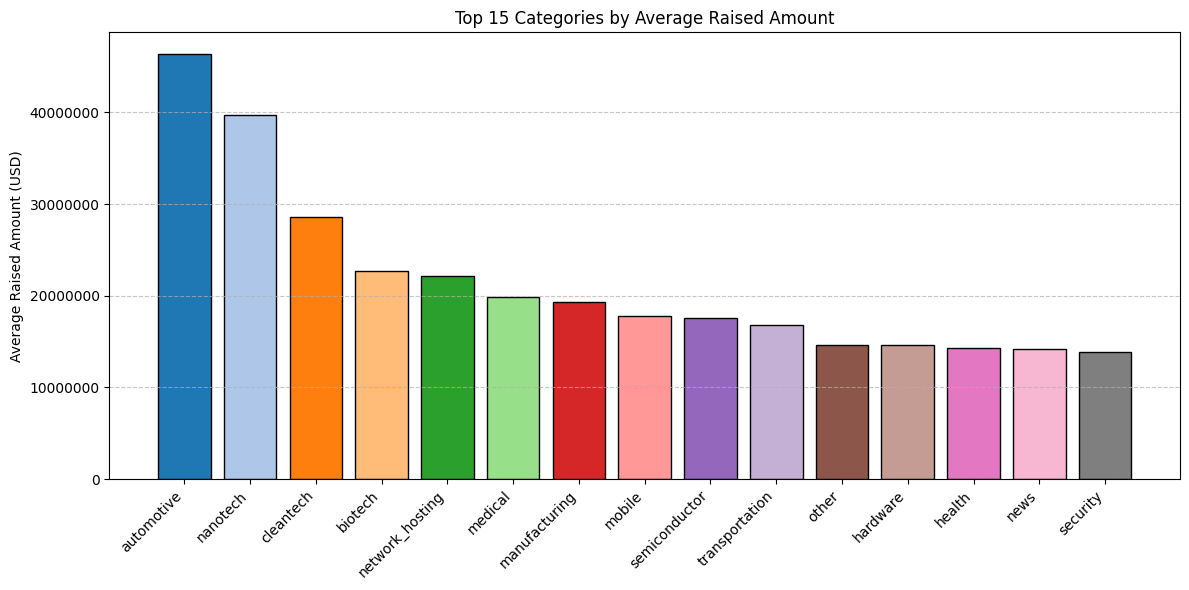

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)

# Query and prepare data
df = pd.read_sql("""
                SELECT company_category_code, AVG(raised_amount_usd)
                FROM investments
                GROUP BY company_category_code
                ORDER BY AVG(raised_amount_usd) DESC;
                """, conn)

df = df.set_index('company_category_code')

# Select top N categories
top_n = 15
top_df = df.head(top_n)

# Generate distinct colors for each bar
colors = sns.color_palette('tab20', n_colors=top_n)

# Plot with unique colors for each bar
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(top_df.index, top_df['AVG(raised_amount_usd)'], color=colors, edgecolor='black')

# Customize the plot
ax.set_ylabel('Average Raised Amount (USD)')
ax.set_title(f'Top {top_n} Categories by Average Raised Amount')
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45, ha='right')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
